<a href="https://colab.research.google.com/github/ThakdanaiSaelee/Lab_CE888/blob/main/lab6%20-%20recommender/my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error

# Libraries for pre-processing
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv",header=None)
df.shape

(24983, 101)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.0,99.00,99.0,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,...,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.0,99.00,99.0,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,...,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.0,99.00,99.0,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.0,99.00,99.0,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [4]:
# replace 99 by Nan because 99 mean 'not rate'
df = df.replace(99, np.nan)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74.0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,100.0,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49.0,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,48.0,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,91.0,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [5]:
# Drop first column that in not a rating
df = df.drop(labels = 0, axis=1)
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [6]:
# find the best and worst joke using mean value
mean_score = df.mean(axis = 0)
max = -10
max_joke = 0
min = 10
min_joke = 0
for i, v in enumerate(mean_score):
  if v > max:
    max = v
    max_joke = i + 1
  if v < min:
    min = v
    min_joke = i + 1
print('best joke is:',max_joke,'with score:',max,'and worst joke is:',min_joke,'with score',min)

best joke is: 50 with score: 3.6650848950824937 and worst joke is: 58 with score -3.8338796373689923


In [7]:
real_data = df.values

In [8]:
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_data = orig.copy()
  rated = np.where(~np.isnan(orig))                                                  # rated[0] = row, rated[1] = column
  n_rated = len(rated[0])                                                            # row
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = np.nan
  return new_data, (rated[0][idx], rated[1][idx])

In [9]:
# create New data set 
train_data , index = replace(real_data,0.1)

In [10]:
print(real_data[index[0][1],index[1][1]])

0.29


In [11]:
print(train_data[index[0][1],index[1][1]])

nan


In [12]:
n_latent_factors = 2

# Initialise as random values
latent_user_preferences = np.random.random((real_data.shape[0], n_latent_factors))
latent_item_features = np.random.random((real_data.shape[1], n_latent_factors))

In [13]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)           # predicting value
    err =  predicted_rating - rating                              # find error
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id] # update new value
    latent_item_features[item_id] -= alpha * err * user_pref_values                 # update new value
    return err
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = train_data[user_id, item_id]                    # real rating
                if not np.isnan(rating):
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 1) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

Iteration 0/10:	MSE=26.246798
Iteration 1/10:	MSE=25.290703
Iteration 2/10:	MSE=25.001919
Iteration 3/10:	MSE=24.783181
Iteration 4/10:	MSE=24.571565
Iteration 5/10:	MSE=24.358530
Iteration 6/10:	MSE=24.143210
Iteration 7/10:	MSE=23.926371
Iteration 8/10:	MSE=23.709252
Iteration 9/10:	MSE=23.493228


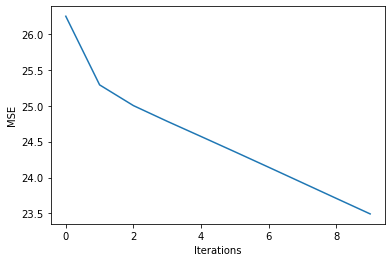

In [14]:
num_iter = 10
hist = sgd(num_iter)

plt.figure()
plt.plot(np.arange(0, num_iter,1), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

In [15]:
# find mse in test data
real_rating = np.zeros(len(index[0]))
pred_rating = np.zeros(len(index[0]))
for i in range(len(index[0])):
  real_rating[i] = real_data[index[0][i],index[1][i]]
  pred_rating[i] = predict_rating(index[0][i],index[1][i])

mse_error = mean_squared_error(real_rating, pred_rating)
print('mse from test set:',mse_error)

mse from test set: 23.631746312795915


In [16]:
real_data[118, 11]

7.52

In [17]:
predictions = latent_user_preferences.dot(latent_item_features.T)
predictions

array([[1.25170401, 0.72525731, 0.70221587, ..., 1.31514949, 0.53579331,
        1.72831809],
       [0.6960015 , 0.47077635, 0.51993608, ..., 0.8898499 , 0.33304037,
        1.2672588 ],
       [1.48447799, 0.93250853, 0.97163074, ..., 1.72974712, 0.67308539,
        2.37808775],
       ...,
       [0.71715361, 0.42478518, 0.42008046, ..., 0.77524505, 0.31179304,
        1.03221295],
       [1.1475037 , 0.68148109, 0.67559698, ..., 1.24466078, 0.49982551,
        1.65974714],
       [1.53228377, 0.89640739, 0.87607596, ..., 1.63010104, 0.66035811,
        2.15464957]])

In [18]:
values = [zip(real_data[i], predictions[i]) for i in range(predictions.shape[0])]
comparison_data = pd.DataFrame(values)

In [19]:
comparison_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,"(-7.82, 1.2517040109250448)","(8.79, 0.7252573137049037)","(-9.66, 0.7022158681936871)","(-8.16, -0.7179085984337688)","(-7.52, 0.7274090729705197)","(-8.5, 1.963343175528168)","(-9.85, 0.04699093458321034)","(4.17, -0.3417750708913799)","(-8.98, 0.011864503870030204)","(-4.76, 1.4522809612044745)","(-8.5, 2.0553502818832494)","(-6.75, 1.9950925722939135)","(-7.18, -1.2361031978662984)","(8.45, 1.9373115280873445)","(-7.18, -1.3040783244105756)","(-7.52, -2.553243007390885)","(-7.43, -0.6068051323537581)","(-9.81, -0.3483870889588221)","(-9.85, 0.5606505647515273)","(-9.85, -0.36838805445562817)","(-9.37, 2.4508339662928247)","(1.5, 1.3507078766555443)","(-4.37, 0.48549898867716385)","(-9.81, -1.0220033576155336)","(-8.5, 0.9958984473354153)","(1.12, 1.8292282160170952)","(7.82, 3.206168132741625)","(2.86, 1.9289098223510617)","(9.13, 3.0227822501557062)","(-7.43, 0.2007386312044107)","(2.14, 2.5084825475013304)","(-4.08, 3.1479208623477497)","(-9.08, -0.6618325677851771)","(7.82, 1.5161316541210252)","(5.05, 3.101755056060672)","(4.95, 3.2609123713239)","(-9.17, -0.7369642216893623)","(-8.4, 1.5827603252183338)","(-8.4, 1.5552851457723833)","(-8.4, 1.3855524669706627)",...,"(8.59, 2.765736406633749)","(3.59, 3.1586548565669745)","(-6.84, 0.8598863272284174)","(-9.03, -0.2140772955842101)","(2.82, 2.61704123498469)","(-1.36, 2.7708962313404175)","(-9.08, -0.31462202710189957)","(8.3, 2.839426816713198)","(5.68, 2.9094802396280026)","(-4.81, 0.9561798095150349)","(nan, -0.008450204710943494)","(nan, 2.8320363611060513)","(nan, 1.4237809325122768)","(nan, -0.8808347148156502)","(nan, 0.34077701413475997)","(nan, 2.497739320267051)","(nan, 0.9996540100589513)","(-9.42, 2.0900206980447997)","(nan, 0.7784837399443932)","(nan, 1.6318411352492657)","(nan, 2.283741226456947)","(-7.72, 1.3572482892650657)","(nan, 2.398879275349983)","(nan, 0.9379001349766533)","(nan, 1.3375885911925167)","(nan, 0.6284265112359607)","(nan, 2.1363373840041193)","(nan, 2.305581734478069)","(nan, 3.495616705155877)","(nan, 1.0949245106253684)","(2.82, 2.2677801662518893)","(nan, 1.5831584664679206)","(nan, 2.7287775985119413)","(nan, 1.5147621867766452)","(nan, 1.1361216881968625)","(nan, 1.7052959356440398)","(-5.63, 1.8396841444941614)","(nan, 1.315149487031162)","(nan, 0.5357933141391906)","(nan, 1.728318086585996)"
1,"(4.08, 0.6960014974299723)","(-0.29, 0.470776346347612)","(6.36, 0.5199360815476646)","(4.37, -0.5665021942502866)","(-2.38, 0.5416217098687677)","(-9.66, 1.352580520177917)","(-0.73, -0.11171206473356686)","(-5.34, -0.264670735882876)","(8.88, -0.1294940721632563)","(9.22, 1.0129195971817773)","(6.75, 1.4808376638720855)","(8.64, 1.310796037122566)","(4.42, -1.0030912501429727)","(7.43, 1.2640688913535152)","(4.56, -1.068946233330307)","(-0.97, -1.8079510133360028)","(4.66, -0.467089057019369)","(-0.68, -0.21939741085825426)","(3.3, 0.32427655266547295)","(-1.21, -0.32665136209229206)","(0.87, 1.7483456540795868)","(8.64, 0.8715326165325059)","(8.35, 0.4263486862416083)","(9.17, -0.7895874546009173)","(0.05, 0.5625764352120362)","(7.57, 1.190903160655448)","(4.71, 2.360468397476475)","(0.87, 1.2992467804052368)","(-0.39, 2.2313165355955524)","(6.99, 0.12507965733091156)","(6.5, 1.7491996608186509)","(-0.92, 2.3471216221915654)","(7.14, -0.48434126492064417)","(9.03, 0.9251040026539125)","(-1.8, 2.2368969326647252)","(0.73, 2.3828475798630726)","(7.09, -0.5821725149156568)","(3.4, 1.099175322181285)","(-0.87, 1.1303505999629797)","(7.91, 1.0535517400277215)",...,"(-6.7, 1.8970874858860967)","(-3.35, 2.177593308819306)","(-9.03, 0.4919742806107736)","(4.47, -0.09975604747024253)","(4.08, 1.8671936329099639)","(-3.83, 1.9615139758205322)","(8.74, -0.21989441036357335)","(1.12, 1.9808680157780265)","(0.78, 1

**Movie dataset**

In [20]:
# load the data
df_movie = pd.read_excel("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/movies_latent_factors.xlsx",sheet_name='Items',index_col='Movie ID')
df_movie.head()

,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
Movie ID,,,,,,,,,,,,,,,,
11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
12,Finding Nemo (2003),-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
14,American Beauty (1999),-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
22,Pirates of the Caribbean: The Curse of the Bla...,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566


In [21]:
# drop data that not a factor
df_movie_notitle = df_movie.drop(labels = 'Title', axis=1)

In [22]:
df_user = pd.read_excel("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/movies_latent_factors.xlsx",sheet_name='Users',index_col='User')
df_user.head()

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
User,,,,,,,,,,,,,,,
4768,-0.204024,0.161079,-0.090447,0.138495,-0.162934,0.163894,0.051502,-0.088582,0.126829,0.065967,0.085008,0.355404,0.007108,-0.118663,-0.039125
156,-0.189652,-0.178979,-0.091490,-0.000823,-0.032646,0.177209,-0.098123,-0.068283,-0.011575,0.120866,-0.009931,-0.048606,0.045916,0.113671,0.179873
5323,-0.115308,-0.090886,-0.053129,0.018472,-0.068081,-0.004828,0.113005,0.102107,0.034758,0.000693,-0.073712,-0.019460,0.108372,0.054471,-0.109552
174,-0.227462,-0.272532,-0.017231,0.054324,0.214755,-0.072639,-0.033122,-0.086508,-0.131479,0.180403,0.095890,-0.082396,0.036767,-0.165438,0.050692
4529,-0.014616,-0.102218,-0.107935,0.155784,-0.123362,-0.118228,-0.013549,-0.050622,0.058698,-0.159600,-0.142382,-0.132836,-0.039897,0.129063,0.102669


In [23]:
predictions_movie = df_user.values.dot(df_movie_notitle.values.T)
predictions_movie

array([[ 0.38917446,  0.1914492 ,  0.76636376, ..., -0.39512894,
        -0.52241157,  0.09700956],
       [ 0.88306881,  0.31949613,  0.3964848 , ..., -0.25938454,
        -0.45546187, -0.11338139],
       [ 0.214068  ,  0.15453744,  0.26107296, ..., -0.0836334 ,
        -0.16392863, -0.1998398 ],
       ...,
       [-0.1839868 , -0.14607304,  1.05742572, ...,  0.08441399,
        -0.09190705, -0.58875059],
       [ 0.56432569,  0.02513325,  0.23432597, ..., -0.52631953,
        -0.46112085, -0.19698778],
       [-0.00710234,  0.15005546,  0.42873279, ..., -0.16656866,
        -0.21864697, -0.15514781]])

In [24]:
predict_movie_data = pd.DataFrame(predictions_movie)
predict_movie_data.columns = df_movie.index
predict_movie_data.index = df_user.index
predict_movie_data

Movie ID,11,12,13,14,22,24,38,63,77,85,98,105,107,114,120,121,122,134,141,146,153,155,161,180,187,194,197,238,243,268,272,274,275,278,280,329,393,414,424,453,...,745,752,786,788,807,808,809,812,854,857,862,954,955,1422,1572,1597,1637,1891,1892,1894,1900,2024,2164,2501,2502,3049,4327,5503,7443,8358,8467,8587,9331,9741,9802,9806,10020,36657,36658,36955
User,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4768,0.389174,0.191449,0.766364,-0.190918,-0.610322,-0.388917,-0.004002,0.190730,0.268826,1.188110,0.195472,1.075866,0.490713,-0.514578,-0.370327,-0.506850,-0.416795,0.263785,0.069576,-0.461273,-0.168938,0.248981,-0.088369,-0.320207,-0.171628,0.058226,0.287472,0.634223,0.216470,-0.269254,-0.023449,0.532674,0.471114,0.937787,0.414122,0.243899,-0.465304,-1.140411,0.593612,0.080442,...,0.366176,-0.402584,0.050475,0.149423,0.541162,0.661988,0.055876,-0.112212,-0.039461,0.450075,0.525795,-0.361932,-1.052730,0.378917,0.237825,0.309767,-0.154147,0.416629,0.304657,-1.417385,0.061697,-0.266492,-0.079663,0.543639,0.341835,0.129791,-1.246529,0.567501,-0.031013,0.077461,0.526472,-0.053100,0.116875,-0.167823,0.207883,0.248880,-0.264199,-0.395129,-0.522412,0.097010
156,0.883069,0.319496,0.396485,-0.380979,-0.187145,-0.862520,-0.119464,-0.044719,0.082417,0.345774,0.658106,0.510767,-0.125068,-0.151969,0.517930,0.472757,0.561092,-0.221019,-0.129598,-0.208213,-0.225939,0.702483,0.189687,0.337877,-0.260572,-0.292796,0.404124,-0.049005,-0.129483,-0.550813,0.336472,-0.119816,-0.242805,0.293419,0.268176,0.577851,-0.884860,-1.023764,0.199863,0.514953,...,0.304296,0.409391,-0.229632,-0.136578,-0.101327,-0.106959,-0.488648,-0.003041,-0.561891,0.251416,0.269787,0.052700,-0.328004,0.046813,0.016504,-0.218339,-0.111493,0.910234,0.885208,0.409308,-0.218698,0.033565,0.277388,0.277319,0.220398,-0.637950,-1.423655,0.097996,-0.354999,0.122281,-0.500473,0.357837,-0.041433,-0.072079,0.048516,0.062227,-0.179019,-0.259385,-0.455462,-0.113381
5323,0.214068,0.154537,0.261073,-0.187174,0.502264,0.447514,-0.258614,-0.293113,-0.104059,0.073767,0.543291,0.045008,-0.059968,-0.036395,0.247560,0.237873,0.285821,-0.316820,-0.344919,-0.128238,-0.466908,0.759871,0.265635,-0.257978,-0.153931,-0.233692,0.360666,0.694714,-0.386115,0.027994,0.428741,0.192190,-0.259231,0.478752,0.327803,0.136766,0.372406,-0.399539,0.271648,0.181640,...,-0.086112,-0.018083,-0.393651,-0.302412,-0.066160,0.209991,0.010296,0.322565,-0.111107,0.228516,0.266962,0.169295,-0.032999,0.283415,0.106452,-0.271994,-0.156425,0.186516,0.101966,-0.421808,-0.256815,-0.018047,-0.302059,0.132926,0.080893,-0.199164,-0.413831,-0.097153,-0.334807,-0.106210,-0.517215,0.667856,-0.217218,-0.390654,-0.111029,0.046301,0.242631,-0.083633,-0.163929,-0.199840
174,-0.139366,0.129855,1.212876,-0.411287,0.484533,-0.865355,-0.162480,-0.028759,-0.096787,-0.187731,0.770433,-0.075722,-0.052166,-0.353584,1.858963,1.892477,1.891704,-0.352995,-0.238122,-0.155691,-0.465392,0.315802,-0.063346,0.164196,0.000219,-0.147500,0.776647,0.060033,-0.237285,-0.605052,-0.105234,0.085034,-0.552006,0.668020,-0.359605,-0.101019,-0.760042,-0.412730,0.558233,0.995228,...,0.468163,0.700335,-0.304751,-0.097778,0.158311,0.559324,0.103477,-0.223986,-0.366725,0.303603,-0.074221,-0.587257,-0.648043,-0.069623,-0.264658,-0.382602,-0.414798,-0.091951,-0.054668,0.499982,-0.226226,0.233677,0.175190,-0.197097,-0.192601,-1.233248,-1.337438,-0.163425,-0.334595,0.352293,-1.370533,0.271769,-0.125226,0.050462,0.132708,-0.197997,-0.307370,0.138995,0.003095,-0.524709
4529,-0.038172,0.866052,-0.285316,0.016812,-0.249510,-0.702938,0.144358,-0.233250,0.253279,-0.146575,0.146374,-0.211549,-0.511296,0.149259,-0.215623,-0.246139,-0.158675,-0.085058,-0.153884,0.230182,0.171180,0.817499,0.003485,-0.007810,-0.564633,0.095389,-0.266832,0.163397,-0.165875,-0.066653,0.722882,-0.110033,0.047110,0.069928,-0.051499,0.511015,-0.674589,-0.460420,-0.017807,0.089402,...,0.039535,-0.003985,-0.054086,-0.236235,-0.297127,-0.120728,-0.136538,0.495312,-0.586712,0.1

In [25]:
predict_movie_data.loc[2067 , 809]

-0.31115793560732985

In [26]:
predict_movie_data.loc[768, 809]

-0.03953324078478367

In [27]:
predict_movie_data.sort_values(by = [4373], axis=1, ascending=False)

Movie ID,603,105,329,85,745,280,13,585,862,278,568,9806,12,601,453,77,2501,155,180,5503,640,607,808,98,854,38,2502,63,629,857,424,8358,1637,153,788,275,274,9741,641,807,...,8587,752,14,9331,1422,462,134,197,1891,557,161,121,664,107,3049,1900,7443,36658,1892,809,11,146,812,671,597,2024,558,114,10020,672,22,955,187,268,680,1894,414,4327,393,24
User,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4768,-0.194970,1.075866,0.243899,1.188110,0.366176,0.414122,0.766364,0.308922,0.525795,0.937787,0.402581,0.248880,0.191449,0.315561,0.080442,0.268826,0.543639,0.248981,-0.320207,0.567501,0.292441,-0.178272,0.661988,0.195472,-0.039461,-0.004002,0.341835,0.190730,0.658774,0.450075,0.593612,0.077461,-0.154147,-0.168938,0.149423,0.471114,0.532674,-0.167823,0.030802,0.541162,...,-0.053100,-0.402584,-0.190918,0.116875,0.378917,-0.034109,0.263785,0.287472,0.416629,-0.802347,-0.088369,-0.506850,-0.500927,0.490713,0.129791,0.061697,-0.031013,-0.522412,0.304657,0.055876,0.389174,-0.461273,-0.112212,0.027140,-1.822833,-0.266492,-1.109817,-0.514578,-0.264199,0.019741,-0.610322,-1.052730,-0.171628,-0.269254,0.659829,-1.417385,-1.140411,-1.246529,-0.465304,-0.388917
156,1.052255,0.510767,0.577851,0.345774,0.304296,0.268176,0.396485,0.272416,0.269787,0.293419,0.322640,0.062227,0.319496,0.158998,0.514953,0.082417,0.277319,0.702483,0.337877,0.097996,0.251148,-0.020542,-0.106959,0.658106,-0.561891,-0.119464,0.220398,-0.044719,-0.049977,0.251416,0.199863,0.122281,-0.111493,-0.225939,-0.136578,-0.242805,-0.119816,-0.072079,-0.017998,-0.101327,...,0.357837,0.409391,-0.380979,-0.041433,0.046813,-0.139287,-0.221019,0.404124,0.910234,-0.773939,0.189687,0.472757,-0.054057,-0.125068,-0.637950,-0.218698,-0.354999,-0.455462,0.885208,-0.488648,0.883069,-0.208213,-0.003041,-0.877864,0.101975,0.033565,-1.072961,-0.151969,-0.179019,-0.896608,-0.187145,-0.328004,-0.260572,-0.550813,-0.449067,0.409308,-1.023764,-1.423655,-0.884860,-0.862520
5323,0.210838,0.045008,0.136766,0.073767,-0.086112,0.327803,0.261073,-0.003845,0.266962,0.478752,-0.284087,0.046301,0.154537,-0.179812,0.181640,-0.104059,0.132926,0.759871,-0.257978,-0.097153,0.106892,0.103008,0.209991,0.543291,-0.111107,-0.258614,0.080893,-0.293113,0.037463,0.228516,0.271648,-0.106210,-0.156425,-0.466908,-0.302412,-0.259231,0.192190,-0.390654,-0.311456,-0.066160,...,0.667856,-0.018083,-0.187174,-0.217218,0.283415,-0.306683,-0.316820,0.360666,0.186516,-0.167830,0.265635,0.237873,-0.450451,-0.059968,-0.199164,-0.256815,-0.334807,-0.163929,0.101966,0.010296,0.214068,-0.128238,0.322565,-0.311259,0.451547,-0.018047,-0.245624,-0.036395,0.242631,-0.274999,0.502264,-0.032999,-0.153931,0.027994,0.404663,-0.421808,-0.399539,-0.413831,0.372406,0.447514
174,1.148704,-0.075722,-0.101019,-0.187731,0.468163,-0.359605,1.212876,0.369320,-0.074221,0.668020,0.078198,-0.197997,0.129855,-0.020320,0.995228,-0.096787,-0.197097,0.315802,0.164196,-0.163425,0.228000,-0.088394,0.559324,0.770433,-0.366725,-0.162480,-0.192601,-0.028759,-0.229629,0.303603,0.558233,0.352293,-0.414798,-0.465392,-0.097778,-0.552006,0.085034,0.050462,0.044370,0.158311,...,0.271769,0.700335,-0.411287,-0.125226,-0.069623,-0.001440,-0.352995,0.776647,-0.091951,-0.434792,-0.063346,1.892477,-0.173307,-0.052166,-1.233248,-0.226226,-0.334595,0.003095,-0.054668,0.103477,-0.139366,-0.155691,-0.223986,0.135280,-0.563474,0.233677,-0.607887,-0.353584,-0.307370,0.105080,0.484533,-0.648043,0.000219,-0.605052,-0.447152,0.499982,-0.412730,-1.337438,-0.760042,-0.865355
4529,0.249057,-0.211549,0.511015,-0.146575,0.039535,-0.051499,-0.285316,0.360410,0.768090,0.069928,-0.032491,0.796196,0.866052,0.264047,0.089402,0.253279,0.174816,0.817499,-0.007810,-0.134954,-0.018534,-0.502076,-0.120728,0.146374,-0.586712,0.144358,0.167268,-0.233250,0.042125,0.165301,-0.017807,-0.098494,-0.133716,0.171180,-0.236235,0.047110,-0.110033,-0.158656,-0.153712,-0.297127,...,0.750208,-0.003985,0.016812,-0.199120,0.011385,-0.133422,-0.085058,-0.266832,0.060928,0.741674,0.00348

In [28]:
predict_movie_data.sort_values(by = [3947], axis=1, ascending=False)

Movie ID,603,604,453,153,2501,2502,597,568,77,1894,745,180,1892,1891,38,640,278,155,955,11,954,98,272,13,329,641,8358,194,105,238,5503,9741,424,664,161,243,414,786,601,557,...,120,550,274,1597,7443,1422,280,1900,809,134,854,121,8587,9802,9331,8467,2024,22,807,808,752,36955,607,862,197,114,268,812,146,3049,107,10020,672,1572,671,4327,187,680,393,24
User,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4768,-0.194970,-2.280878,0.080442,-0.168938,0.543639,0.341835,-1.822833,0.402581,0.268826,-1.417385,0.366176,-0.320207,0.304657,0.416629,-0.004002,0.292441,0.937787,0.248981,-1.052730,0.389174,-0.361932,0.195472,-0.023449,0.766364,0.243899,0.030802,0.077461,0.058226,1.075866,0.634223,0.567501,-0.167823,0.593612,-0.500927,-0.088369,0.216470,-1.140411,0.050475,0.315561,-0.802347,...,-0.370327,0.397611,0.532674,0.309767,-0.031013,0.378917,0.414122,0.061697,0.055876,0.263785,-0.039461,-0.506850,-0.053100,0.207883,0.116875,0.526472,-0.266492,-0.610322,0.541162,0.661988,-0.402584,0.097010,-0.178272,0.525795,0.287472,-0.514578,-0.269254,-0.112212,-0.461273,0.129791,0.490713,-0.264199,0.019741,0.237825,0.027140,-1.246529,-0.171628,0.659829,-0.465304,-0.388917
156,1.052255,0.660557,0.514953,-0.225939,0.277319,0.220398,0.101975,0.322640,0.082417,0.409308,0.304296,0.337877,0.885208,0.910234,-0.119464,0.251148,0.293419,0.702483,-0.328004,0.883069,0.052700,0.658106,0.336472,0.396485,0.577851,-0.017998,0.122281,-0.292796,0.510767,-0.049005,0.097996,-0.072079,0.199863,-0.054057,0.189687,-0.129483,-1.023764,-0.229632,0.158998,-0.773939,...,0.517930,0.063528,-0.119816,-0.218339,-0.354999,0.046813,0.268176,-0.218698,-0.488648,-0.221019,-0.561891,0.472757,0.357837,0.048516,-0.041433,-0.500473,0.033565,-0.187145,-0.101327,-0.106959,0.409391,-0.113381,-0.020542,0.269787,0.404124,-0.151969,-0.550813,-0.003041,-0.208213,-0.637950,-0.125068,-0.179019,-0.896608,0.016504,-0.877864,-1.423655,-0.260572,-0.449067,-0.884860,-0.862520
5323,0.210838,-0.490145,0.181640,-0.466908,0.132926,0.080893,0.451547,-0.284087,-0.104059,-0.421808,-0.086112,-0.257978,0.101966,0.186516,-0.258614,0.106892,0.478752,0.759871,-0.032999,0.214068,0.169295,0.543291,0.428741,0.261073,0.136766,-0.311456,-0.106210,-0.233692,0.045008,0.694714,-0.097153,-0.390654,0.271648,-0.450451,0.265635,-0.386115,-0.399539,-0.393651,-0.179812,-0.167830,...,0.247560,0.265523,0.192190,-0.271994,-0.334807,0.283415,0.327803,-0.256815,0.010296,-0.316820,-0.111107,0.237873,0.667856,-0.111029,-0.217218,-0.517215,-0.018047,0.502264,-0.066160,0.209991,-0.018083,-0.199840,0.103008,0.266962,0.360666,-0.036395,0.027994,0.322565,-0.128238,-0.199164,-0.059968,0.242631,-0.274999,0.106452,-0.311259,-0.413831,-0.153931,0.404663,0.372406,0.447514
174,1.148704,1.044419,0.995228,-0.465392,-0.197097,-0.192601,-0.563474,0.078198,-0.096787,0.499982,0.468163,0.164196,-0.054668,-0.091951,-0.162480,0.228000,0.668020,0.315802,-0.648043,-0.139366,-0.587257,0.770433,-0.105234,1.212876,-0.101019,0.044370,0.352293,-0.147500,-0.075722,0.060033,-0.163425,0.050462,0.558233,-0.173307,-0.063346,-0.237285,-0.412730,-0.304751,-0.020320,-0.434792,...,1.858963,0.100185,0.085034,-0.382602,-0.334595,-0.069623,-0.359605,-0.226226,0.103477,-0.352995,-0.366725,1.892477,0.271769,0.132708,-0.125226,-1.370533,0.233677,0.484533,0.158311,0.559324,0.700335,-0.524709,-0.088394,-0.074221,0.776647,-0.353584,-0.605052,-0.223986,-0.155691,-1.233248,-0.052166,-0.307370,0.105080,-0.264658,0.135280,-1.337438,0.000219,-0.447152,-0.760042,-0.865355
4529,0.249057,0.114047,0.089402,0.171180,0.174816,0.167268,1.625952,-0.032491,0.253279,-0.492626,0.039535,-0.007810,-0.106457,0.060928,0.144358,-0.018534,0.069928,0.817499,0.173325,-0.038172,0.179368,0.146374,0.722882,-0.285316,0.511015,-0.153712,-0.098494,0.095389,-0.211549,0.163397,-0.134954,-0.158656,-0.017807,-0.103303,0.003485,-0.165875,-0.460420,-0.054086,0.264047,0.741674,...,-0.215623,-0.247488,-0.110033,-0.311510,0.082399,0.011385,-0.051499,-0.105881,-0.136538,-0.085058,-0.586